In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [3]:
# Load data 
df = pd.read_csv("data/all_preprocessed_tasks_EN.csv") 
df = df.dropna(subset=["description"])
df = df[df["word_count"] > 4] # removing test descriptions
df.reset_index(inplace=True, drop=True)
data = df["description"].tolist() 
sentences_tokens = [sentence.lower().split() for sentence in data]
df.head()

,taskId,language,description,topic_id,word_count
0,9oqJmtbKXts6Rr9Szw4OIS,eng,cours client book swiss connect academi,NaN,6
1,a0pzxEfKq8c9D0dRZlQcm9,eng,write rule astronaut use condit sentenc exampl...,NaN,20
2,9Hjn2yUwBcs7DZK6HARkE4,eng,guess frequent speak languag switzerland use m...,NaN,14
3,6AYw9CEZMTN7LN8u0LfYVb,eng,complet sentenc go exampl plan tonight rain wa...,NaN,16
4,8QIKtMOE9zV6lnfc2vHMUd,eng,follow exampl veget carrot potato lettuc brocc...,NaN,11


> **Distribution of words:** Refer to 4_concat_data.ipynb

# Embedding

In [4]:
# We compute the embedding of the entire sentence as the average of the embeddings of its words. 
# One of the problems of this approach is that it ignores the order of the words in the sentences. 
# Another problem is that all words are given the same weight. 
# The third issue is information loss. 
# https://www.baeldung.com/cs/sentence-vectors-word2vec 
def meanEmbedding(model, words):
    # remove out-of-vocabulary words
    vocab = model.wv.index_to_key
    words = [word for word in words if word in vocab]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.array([])

In [5]:
# Weighted Averaging 
# Use TF-IDF score as the weight of each word (frequent words have a smaller TF-IDF score) 
# Solves problem of equal importance given to all words with normal averaging, but doesn't fix the order of words problem. 
def get_tfidf(data):
    # Vectorizer 
    vectorizer = TfidfVectorizer(
        max_df=0.9,
        min_df=0.01,
        stop_words=stopwords.words('english'),
    )

    tfidf = vectorizer.fit_transform(data)
    tfidf_word_list = vectorizer.get_feature_names_out()
    # print(f"n_samples: {tfidf.shape[0]}, n_features: {tfidf.shape[1]}")
    return tfidf, tfidf_word_list

def weightedMeanEmbedding(model, tfidf, tfidf_word_list, words, doc_idx):
    # remove out-of-vocabulary words
    vocab = model.wv.index_to_key
    words = [word for word in words if word in vocab]
    scores = []
    for word in words: 
        if word in tfidf_word_list: 
            word_idx = list(tfidf_word_list).index(word)
            score = tfidf[doc_idx, word_idx]
        else: 
            score = 0 
        scores.append(score)
    if len(words) >= 1:
        return np.mean(model.wv[words]*np.array(scores).reshape((-1,1)), axis=0)
    else:
        return []


tfidf, tfidf_word_list = get_tfidf(df.description.to_list())

In [6]:
# Deep averaging network 
# Still ignorant about the syntax and order of words of a sentence. 
# despite its simplicity and lightness in contrast with syntactically-aware models, 
# such as recursive neural networks, deep averaging networks perform comparably. 


**CBOW** <br>
The CBOW model learns to predict a target word leveraging all words in its neighborhood. The sum of the context vectors are used to predict the target word.

In [7]:
# Initialize Word2Vec CBOW model
# TODO to adjust min_count (to remove words with very little occurrence), 
# plot distribution of words first, and make a studied decision
# TODO tweak arg `window` = Maximum distance between the current and predicted word within a sentence.
# (=== window=1 takes into account one word at each side of the word to predict)
cbow_model = Word2Vec(sentences=sentences_tokens, min_count=1, vector_size=100, window=1)

# Train model 
cbow_model.train(data, total_examples=len(data), epochs=1)

# length of word_vectors is equal to the number of words in the bag of vocabulary
word_vectors = cbow_model.wv.vectors
len(word_vectors), len(data)

(3399, 1445)

In [8]:
df["CBmeanEmbedding"] = df["description"].apply(
    lambda text: meanEmbedding(
        model=cbow_model, 
        words=text.split()))

In [9]:
tfidf, tfidf_word_list = get_tfidf(df.description.to_list())
df["CBweightedMeanEmbedding"] = df.apply(
    lambda row: weightedMeanEmbedding(
        model=cbow_model, 
        tfidf=tfidf,
        tfidf_word_list=tfidf_word_list,
        words=row["description"].split(), 
        doc_idx=row.name), axis=1)

<hr>

**SKIPGRAM** <br> 
The SkipGram model on the other hand, learns to predict a word based on a neighboring word. To put it simply, given a word, it learns to predict another word in it’s context.

In [10]:
# Word2Vec Skip Gram model
sg_model = Word2Vec(sentences=sentences_tokens, min_count=1, vector_size=100, window=1, sg=1)

# Train model 
sg_model.train(data, total_examples=len(data), epochs=1)

# length of word_vectors is equal to the number of words in the bag of vocabulary
word_vectors = sg_model.wv.vectors
len(word_vectors), len(data)

(3399, 1445)

In [11]:
df["SGmeanEmbedding"] = df["description"].apply(
    lambda text: meanEmbedding(
        model=sg_model, 
        words=text.split()))

In [12]:
df["SGweightedMeanEmbedding"] = df.apply(
    lambda row: weightedMeanEmbedding(
        model=sg_model, 
        tfidf=tfidf,
        tfidf_word_list=tfidf_word_list,
        words=row["description"].split(), 
        doc_idx=row.name), axis=1)

In [13]:
df.head(1)

,taskId,language,description,topic_id,word_count,CBmeanEmbedding,CBweightedMeanEmbedding,SGmeanEmbedding,SGweightedMeanEmbedding
0,9oqJmtbKXts6Rr9Szw4OIS,eng,cours client book swiss connect academi,NaN,6,"[-0.1297508, 0.21280916, 0.09104741, 0.0543678...","[-0.053267644239476435, 0.08872664879809801, 0...","[-0.14988194, 0.25598776, 0.124316044, 0.02500...","[-0.06128151909926436, 0.10690309561161233, 0...."


# Clustering

**CBOW**

In [46]:
emb_mx = np.stack(df["CBmeanEmbedding"].values)
pca_cbme = PCA(n_components=2).fit_transform(emb_mx)

emb_mx = np.stack(df["CBweightedMeanEmbedding"].values)
pca_cbwme = PCA(n_components=2).fit_transform(emb_mx)

**SKIPGRAM**

In [47]:
emb_mx = np.stack(df["SGmeanEmbedding"].values)
pca_sgme = PCA(n_components=2).fit_transform(emb_mx)

emb_mx = np.stack(df["SGweightedMeanEmbedding"].values)
pca_sgwme = PCA(n_components=2).fit_transform(emb_mx)

In [48]:
def plot_elbow(ax, pca, title, save_plot=True):
    wcss = []
    distortions = []
    max=21
    for i in range(1, max):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(pca)
        wcss.append(kmeans.inertia_) 
        
    ax.plot(range(1, max), wcss, marker='o', linestyle='--')    
    
    ax.title.set_text(title)
    # ax.set_ylabel("WCSS")
    # ax.set_xlabel("Number of Clusters")
    ax.grid(True)
    # if save_plot:
    #     ax.get_figure().savefig("figures/clust_elbow_"+language, bbox_inches="tight") 

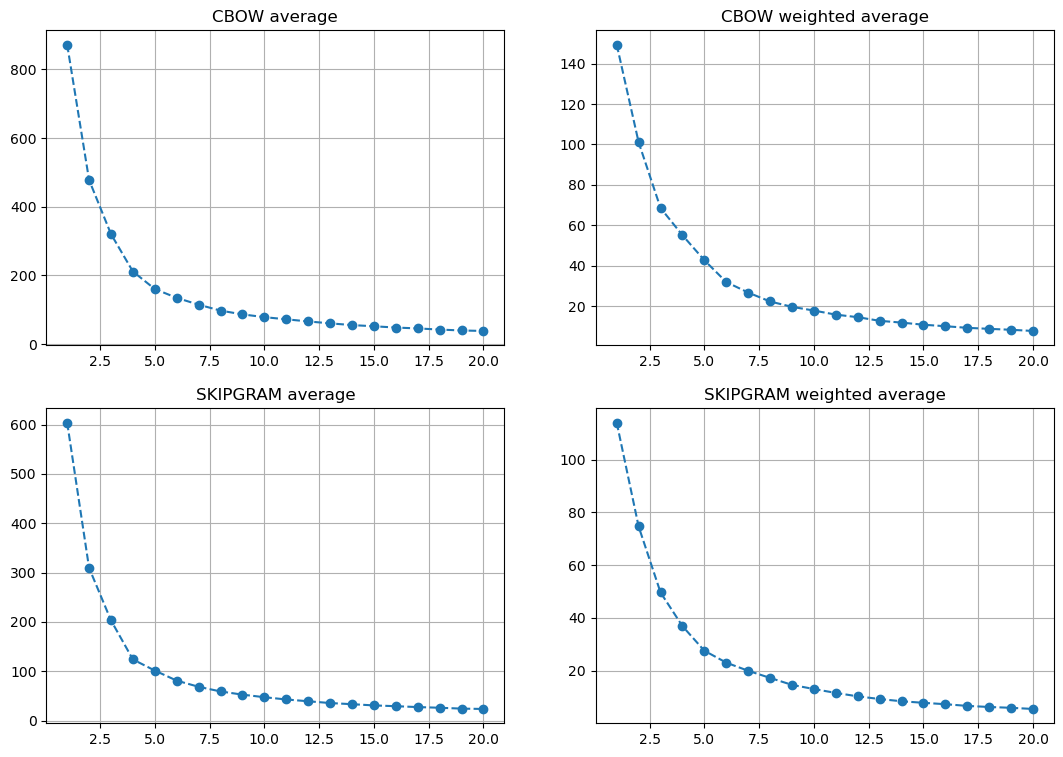

In [50]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(13, 9) 

plot_elbow(
    ax=axs[0][0], 
    pca=pca_cbme, 
    title="CBOW average", 
    save_plot=False)

plot_elbow(
    ax=axs[0][1], 
    pca=pca_cbwme, 
    title="CBOW weighted average", 
    save_plot=False)

plot_elbow(
    ax=axs[1][0], 
    pca=pca_sgme, 
    title="SKIPGRAM average", 
    save_plot=False)

plot_elbow(
    ax=axs[1][1], 
    pca=pca_sgwme, 
    title="SKIPGRAM weighted average", 
    save_plot=False)

In [51]:
# CBOW AVERAGE
kmeans = KMeans(n_clusters=4)
km_cbme = kmeans.fit(pca_cbme) 
# km_cbme = kmeans.fit(emb_mx) 
# pca_cbme = PCA(n_components=2).fit_transform(emb_mx)

# cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
# print("Number of elements assigned")
# print(f"\tcluster 1: {cluster_sizes[0]}") 
# print(f"\tcluster 2: {cluster_sizes[1]}") 
# print(f"\tcluster 3: {cluster_sizes[2]}") 
# print(f"\tcluster 4: {cluster_sizes[3]}") 
# print(f"\tcluster 5: {cluster_sizes[4]}") 

In [52]:
# CBOW WEIGHTED AVERAGE
kmeans = KMeans(n_clusters=6)
km_cbwme = kmeans.fit(pca_cbwme) 

In [53]:
# SKIPGRAM AVERAGE
kmeans = KMeans(n_clusters=4)
km_sgme = kmeans.fit(pca_sgme) 

In [54]:
# SKIPGRAM WEIGHTED AVERAGE
kmeans = KMeans(n_clusters=5)
km_sgwme = kmeans.fit(pca_sgwme) 

# Plotting

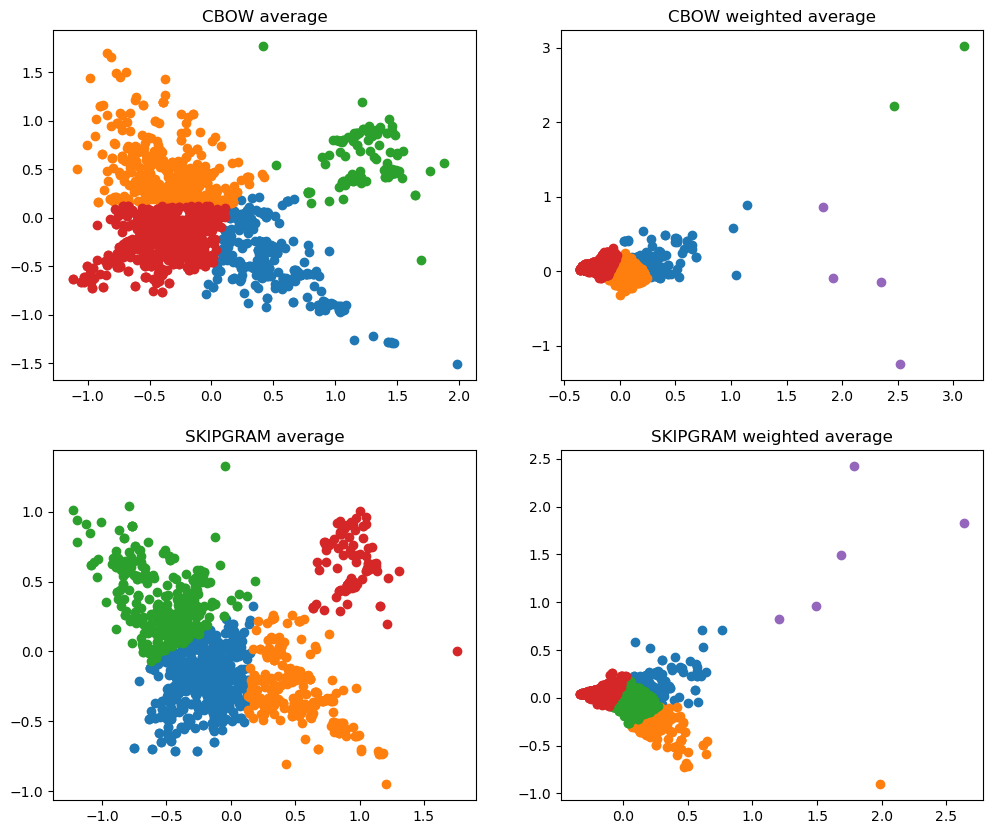

In [55]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(12, 10) 

ax_cbme = axs[0][0] 
ax_cbwme = axs[0][1]
ax_sgme = axs[1][0]
ax_sgwme = axs[1][1]

for cluster in range(k):
    ax_cbme.scatter(pca_cbme[km_cbme.labels_ == cluster, 0], pca_cbme[km_cbme.labels_ == cluster, 1], label=f'Cluster {cluster+1}')
    ax_cbwme.scatter(pca_cbwme[km_cbwme.labels_ == cluster, 0], pca_cbwme[km_cbwme.labels_ == cluster, 1], label=f'Cluster {cluster+1}')
    ax_sgme.scatter(pca_sgme[km_sgme.labels_ == cluster, 0], pca_sgme[km_sgme.labels_ == cluster, 1], label=f'Cluster {cluster+1}')
    ax_sgwme.scatter(pca_sgwme[km_sgwme.labels_ == cluster, 0], pca_sgwme[km_sgwme.labels_ == cluster, 1], label=f'Cluster {cluster+1}')

ax_cbme.title.set_text("CBOW average")
ax_cbwme.title.set_text("CBOW weighted average")
ax_sgme.title.set_text("SKIPGRAM average")
ax_sgwme.title.set_text("SKIPGRAM weighted average")

# plt.legend()
plt.show()

<hr>